<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_1106Remote_rendering_OpenAI_Gym_envs_on_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab で OpenAI の Gym 環境を動かすための下準備

---
- source: https://davidrpugh.github.io/stochastic-expatriate-descent/openai/binder/google-colab/2020/04/16/remote-rendering-gym-envs.html
- date: 2021-1106
- transrator: Shin Asakawa <asakawa@ieee.org>
---

# 1. Binder と Google Colab で OpenAI Gym Envs をレンダリング

軽度の退屈だけど，重要な問題を解決するためのメモ

<!-- Getting OpenAI Gym environments to render properly in remote environments such as Google Colab and Binder turned out to be more challenging than I expected. 
In this post I lay out my solution in the hopes that I might save others time and effort to work it out independently. -->


<!-- # Rendering OpenAI Gym Envs on Binder and Google Colab 
> Notes on solving a mildly tedious (but important) problem
-->
- branch: 2020-04-16-remote-rendering-gym-envs
- badges: true
- image: images/gym-colab-binder.png
- comments: true
- author: David R. Pugh
- categories: [openai, binder, google-colab]


[OpenAI](https://openai.com/) の  [Gym](https://gym.openai.com/docs/) 環境を
 [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb) や [Binder]((https://mybinder.org/) のようなリモート環境で OpenAI Gym 環境を適切にレンダリングすることは，想像以上に難しい。
ここでは， 他の人が独自解決するための時間と労力を節約できるように解決策を紹介します。
<!-- 
Getting [OpenAI](https://openai.com/) [Gym](https://gym.openai.com/docs/) environments to render properly in remote environments such as [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb) and [Binder](https://mybinder.org/) turned out to be more challenging than I expected. In this post I lay out my solution in the hopes that I might save others time and effort to work it out independently. -->

## 1.1 X11 システムの依存関係のインストール

必要な [X11](https://en.wikipedia.org/wiki/X_Window_System) 依存関係をインストールします。
特に [Xvfb](https://www.x.org/releases/X11R7.7/doc/man/man1/Xvfb.1.xhtml) は，ディスプレイハードウェアや物理的な入力デバイスがないマシンでも動作する X サーバです。
<!-- ## Install X11 system dependencies

Install necessary [X11](https://en.wikipedia.org/wiki/X_Window_System) dependencies, in particular [Xvfb](https://www.x.org/releases/X11R7.7/doc/man/man1/Xvfb.1.xhtml), which is an X server that can run on machines with no display hardware and no physical input devices.  -->

In [ ]:
!apt-get install -y xvfb x11-utils

# 1.2 追加のPython依存関係のインストール

Xvfb をインストールしたので Python の中から Xvfb の仮想ディスプレイを操作するために Python のラッパー[pyvirtualdisplay](https://github.com/ponty/PyVirtualDisplay) をインストールする必要があります。

次に [OpenGL](https://www.opengl.org/) の Python バインディングをインストールする必要があります。[PyOpenGL](http://pyopengl.sourceforge.net/) と [PyOpenGL-accelerate](https://pypi.org/project/PyOpenGL-accelerate/) です。

前者は実際の Python バインディングで， 後者はオプションの C (Cyson)  拡張セットであり PyOpenGL 3.x の遅い点に対する一般的な操作の加速を提供します。
<!-- ## Install additional Python dependencies

Now that you have installed Xvfb, you need to install a Python wrapper [`pyvirtualdisplay`](https://github.com/ponty/PyVirtualDisplay) in order to interact with Xvfb virtual displays from within Python. 
Next you need to install the Python bindings for [OpenGL](https://www.opengl.org/): [PyOpenGL](http://pyopengl.sourceforge.net/) and [PyOpenGL-accelerate](https://pypi.org/project/PyOpenGL-accelerate/). 
The former are the actual Python bindings, the latter is and optional set of C (Cython) extensions providing acceleration of common operations for slow points in PyOpenGL 3.x. -->

In [ ]:
!pip install pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

# 1.3 OpenAI Gym のインストール

次に OpenAI Gym のパッケージをインストールします。
ただし， 使用する Gym の環境によっては， 依存関係を追加する必要があります。
下のデモでは `LunarLander-v2` の環境をシミュレートするので [Box2D](https://box2d.org/) 物理シミュレータに依存する Gym 環境を有効にする `box2d` を追加インストールする必要があります。
<!-- ## Install OpenAI Gym

Next you need to install the OpenAI Gym package. 
Note that depending on which Gym environment you are interested in working with you may need to add additional dependencies. 
Since I am going to simulate the LunarLander-v2 environment in my demo below I need to install the `box2d` extra which enables Gym environments that depend on the [Box2D](https://box2d.org/) physics simulator. -->


In [ ]:
!pip install gym[box2d]==0.17.* 

## 1.4 仮想ディスプレイの背景を作成

次に Gym Envs がレンダリングのために接続できる仮想ディスプレイをバックグラウンドに作成する必要があります。 
現在ディスプレイがないことは， 環境変数 [DISPLAY](https://askubuntu.com/questions/432255/what-is-the-display-environment-variable) の値がまだ設定されていないことで確認することができます。
<!-- ## Create a virtual display in the background

Next you need to create a virtual display in the background which the Gym Envs can connect to for rendering purposes. You can check that there is no display at present by confirming that the value of the [`DISPLAY`](https://askubuntu.com/questions/432255/what-is-the-display-environment-variable) environment variable has not yet been set.  -->

In [1]:
!echo $DISPLAY

/private/tmp/com.apple.launchd.sfwRQaoXQd/org.xquartz:0


直下セルのコードは， Gym Envs がレンダリングのために接続できる仮想ディスプレイを背景に作成します。
仮想バッファの `size` は自由に調整できますが Xvfb で作業する際には`visible=False` を設定する必要があります。

**このコードは、ディスプレイを起動するために 1 セッションにつき 1 回だけ実行する必要があります。**

<!-- The code in the cell below creates a virtual display in the background that your Gym Envs can connect to for rendering. 
You can adjust the `size` of the virtual buffer as you like but you must set `visible=False` when working with Xvfb. 

**This code only needs to be run once per session to start the display.** -->

In [2]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"
start failed 1
process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"
start failed 2
process exited early. stderr:b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errn

XStartError: No success after 10 retries. Last stderr: b"_XSERVTransmkdir: ERROR: euid != 0,directory /tmp/.X11-unix will not be created.\n_XSERVTransSocketUNIXCreateListener: mkdir(/tmp/.X11-unix) failed, errno = 2\n_XSERVTransMakeAllCOTSServerListeners: failed to create listener for local\n(EE) \nFatal server error:\n(EE) Cannot establish any listening sockets - Make sure an X server isn't already running(EE) \n"

上のセルを実行した後，環境変数 `DISPLAY` の値を再度表示させ，ディスプレイが動作していることが確認できます。
<!-- After running the cell above you can echo out the value of the `DISPLAY` environment variable again to confirm that you now have a display running. -->

In [ ]:
!echo $DISPLAY

便宜上，上記の手順を 2 つのセルにまとめましたので， コピーして Google Colab のノートブックのトップに貼り付けてください。
<!-- For convenience I have gathered the above steps into two cells that you can copy and paste into the top of you Google Colab notebooks. -->

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [4]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

# 2. デモ

上記の設定が先述のように動作することを証明するため， 簡単なシミュレーションを行ってみます。
まず， 可能な行動集合からランダムに行動を選択する「エージェント」を定義し， そのエージェントを作成するための関数を定義します。
<!-- # 2. Demo

Just to prove that the above setup works as advertised I will run a short simulation. 
First I will define an `Agent` that chooses an action randomly from the set of possible actions and the define a function that can be used to create such agents. -->


In [5]:
import typing
import numpy as np

# 状態を配列で表現し，行動を整数で表現する
State = np.array
Action = int

# エージェントはただの機能
Agent = typing.Callable[[State], Action]

def uniform_random_policy(state: State,
                          number_actions: int,
                          random_state: np.random.RandomState) -> Action:
    """実行可能な行動集合からランダムに行動を選択"""
    feasible_actions = np.arange(number_actions)
    probs = np.ones(number_actions) / number_actions
    action = random_state.choice(feasible_actions, p=probs)
    return action


def make_random_agent(number_actions: int,
                      random_state: np.random.RandomState = None) -> Agent:
    """エージェント作成のためファクトリ"""    
    _random_state = np.random.RandomState() if random_state is None else random_state
    return lambda state: uniform_random_policy(state, number_actions, _random_state)
    

下のセルでは OpenAI Gym 環境の 1 つのエピソードをシミュレートするためのコードをまとめています。
この実装は， 提供された環境が `rgb_array`  レンダリングをサポートしていることを前提としていることに注意してください (すべての Gym 環境がサポートしているわけではありません！)。
<!-- In the cell below I wrap up the code to simulate a single epsiode of an OpenAI Gym environment. 
Note that the implementation assumes that the provided environment supports `rgb_array` rendering (which not all Gym environments support!). -->

In [12]:
import gym
import matplotlib.pyplot as plt
from IPython import display

def simulate(agent: Agent, env: gym.Env) -> None:
    state = env.reset()
    img = plt.imshow(env.render())
    #img = plt.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = agent(state)
        img.set_data(env.render()) 
        #img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)       
    env.close()
    


最後に シミュレーションしたい環境を設定します...
<!-- Finally you can setup your desired environment... -->

In [13]:
#help(lunar_lander_v2.render)

In [14]:
# 月面着陸ゲーム LunarLander
lunar_lander_v2 = gym.make('LunarLander-v2')
#_ = lunar_lander_v2.seed(42)

以下で，シミュレーションの実行します
<!-- ...and run a simulation! -->

/opt/anaconda3/lib/python3.9/site-packages/gym/envs/box2d/lunar_lander.py:604: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


TypeError: Image data of dtype object cannot be converted to float

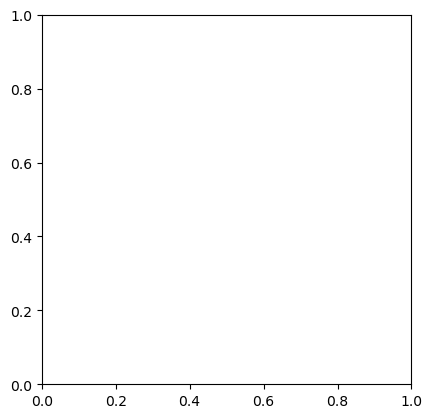

In [15]:
random_agent = make_random_agent(lunar_lander_v2.action_space.n, random_state=None)

simulate(random_agent, lunar_lander_v2)

現在のところ， シミュレーション中に些細な量のちらつきが発生しているようです。
何がこの望ましくない動作を引き起こしているのか， まったくわかりません。
もし， この問題を改善する方法があれば， コメントをお願いします。
良い修正方法が見つかったら， この記事を適宜更新していきます。
<!-- Currently there appears to be a non-trivial amount of flickering during the simulation. 
Not entirely sure what is causing this undesireable behavior. 
If you have any idea how to improve this, please leave a comment below. 
I will be sure to update this post accordingly if I find a good fix. -->

次に倒立振子 `cartpole` 環境を試してみましょう

In [16]:
cartpole = gym.make('CartPole-v0')
_ = cartpole.seed(42)


/opt/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


AttributeError: 'CartPoleEnv' object has no attribute 'seed'

In [17]:
help(cartpole)

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(env: gym.core.Env, max_episode_steps: Optional[int] = None)
 |  
 |  This wrapper will issue a `truncated` signal if a maximum number of timesteps is exceeded.
 |  
 |  If a truncation is not defined inside the environment itself, this is the only place that the truncation signal is issued.
 |  Critically, this is different from the `terminated` signal that originates from the underlying environment as part of the MDP.
 |  
 |  Example:
 |     >>> from gym.envs.classic_control import CartPoleEnv
 |     >>> from gym.wrappers import TimeLimit
 |     >>> env = CartPoleEnv()
 |     >>> env = TimeLimit(env, max_episode_steps=1000)
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: gym.core.Env, max_episode_steps: Optional[int] = Non

/opt/anaconda3/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v0", render_mode="rgb_array")
  gym.logger.warn(


TypeError: Image data of dtype object cannot be converted to float

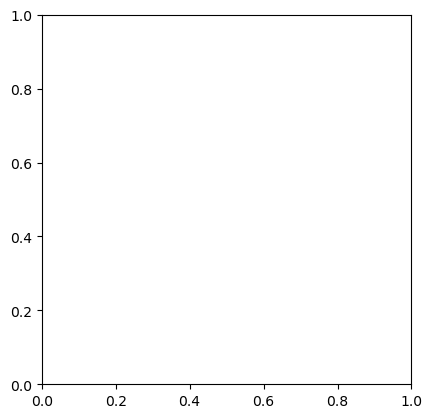

In [18]:
random_agent = make_random_agent(cartpole.action_space.n, random_state=None)
simulate(random_agent, cartpole)